In [1]:
# @title 1. Setup Environment and Imports
# Make sure you are running this in a Colab environment with GPU enabled (Runtime -> Change runtime type)

import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys
import shutil # For potential cleanup

# Install dependencies from your repo's requirements.txt
# To ensure this works, you'll need to clone your repository first in Colab
# or manually upload src/ and scripts/ if you can't clone.

# --- IMPORTANT: CLONE YOUR REPO OR SYNC VIA DRIVE ---
# Option A: Clone the repo directly into Colab's ephemeral environment (recommended for active development)
# This ensures you always use the latest code from your repo.
# Make sure to update the URL with your actual GitHub repo URL
REPO_URL = "https://github.com/HasithaDilshan/agro-ai-copilot" # <--- CUSTOMIZE THIS TO YOUR ACTUAL REPO URL
REPO_NAME = "agro-ai-copilot"

if not os.path.exists(REPO_NAME):
    print(f"Cloning repository: {REPO_URL}")
    !git clone {REPO_URL}
    %cd {REPO_NAME}
    # If using private repo, Colab will ask for credentials or you can set up SSH keys.
else:
    print(f"Repository '{REPO_NAME}' already cloned. Pulling latest changes...")
    %cd {REPO_NAME}
    !git pull origin main # Assuming your development is on main for simplicity, adjust if on feature branch

# Navigate to the specific module directory
%cd module1-edge-ai

# Add project root to Python path to import from src/
project_root_in_colab = os.getcwd() # This will be /content/agro-ai-copilot/module1-edge-ai
if project_root_in_colab not in sys.path:
    sys.path.insert(0, project_root_in_colab)

# Install module-specific dependencies
print(f"Installing requirements from: {os.path.join(project_root_in_colab, 'requirements.txt')}")
!pip install -r requirements.txt
!pip install opencv-python-headless # Often useful for image processing

# --- IMPORTANT: MOUNT GOOGLE DRIVE ---
# This is crucial for accessing your persistently stored data and saving models.
from google.colab import drive
drive.mount('/content/drive')

# --- DEFINE GOOGLE DRIVE PROJECT DATA PATHS (MATCHING drive_setup_project_data_dirs.ipynb) ---
GOOGLE_DRIVE_PROJECT_ROOT = '/content/drive/MyDrive/AgroAI_Project_Data' # <--- ENSURE THIS MATCHES YOUR SETUP!
MODULE1_DRIVE_DATA_DIR = os.path.join(GOOGLE_DRIVE_PROJECT_ROOT, 'module1_edge_ai', 'data')
MODULE1_DRIVE_MODELS_DIR = os.path.join(GOOGLE_DRIVE_PROJECT_ROOT, 'module1_edge_ai', 'trained_models')

# Verify Drive paths exist (they should if setup notebook was run)
if not os.path.exists(MODULE1_DRIVE_DATA_DIR):
    raise FileNotFoundError(f"Module 1 data directory not found in Drive: {MODULE1_DRIVE_DATA_DIR}. Run setup notebook first.")
if not os.path.exists(MODULE1_DRIVE_MODELS_DIR):
    raise FileNotFoundError(f"Module 1 models directory not found in Drive: {MODULE1_DRIVE_MODELS_DIR}. Run setup notebook first.")

print(f"Module 1 data will be accessed from: {MODULE1_DRIVE_DATA_DIR}")
print(f"Module 1 models will be saved to: {MODULE1_DRIVE_MODELS_DIR}")

# Import your custom modules
# Make sure the current directory (module1-edge-ai) and its src/ are in sys.path
# This is handled by %cd and sys.path.insert(0, project_root_in_colab) above
from src.data_utils import create_tf_dataset, get_class_names, prepare_dataset
from src.models import build_fp32_efficientnet_model, IMG_SIZE
from src.loss_functions import WeightedFocalLoss

print("Environment setup and imports complete.")
print(f"TensorFlow version: {tf.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

Repository 'agro-ai-copilot' already cloned. Pulling latest changes...
/content/agro-ai-copilot
From https://github.com/HasithaDilshan/agro-ai-copilot
 * branch            main       -> FETCH_HEAD
Already up to date.
/content/agro-ai-copilot/module1-edge-ai
Installing requirements from: /content/agro-ai-copilot/module1-edge-ai/requirements.txt
  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-model-optimization 0.8.0 requires numpy~=1.23, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.18.0 require

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Module 1 data will be accessed from: /content/drive/MyDrive/AgroAI_Project_Data/module1_edge_ai/data
Module 1 models will be saved to: /content/drive/MyDrive/AgroAI_Project_Data/module1_edge_ai/trained_models
Environment setup and imports complete.
TensorFlow version: 2.18.0
Num GPUs Available: 1


Loading data from: /content/drive/MyDrive/AgroAI_Project_Data/module1_edge_ai/data/PlantVillage_Subset
Found 37998 files belonging to 39 classes.
Found 8128 files belonging to 39 classes.
Found 8179 files belonging to 39 classes.
Found 39 classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', '

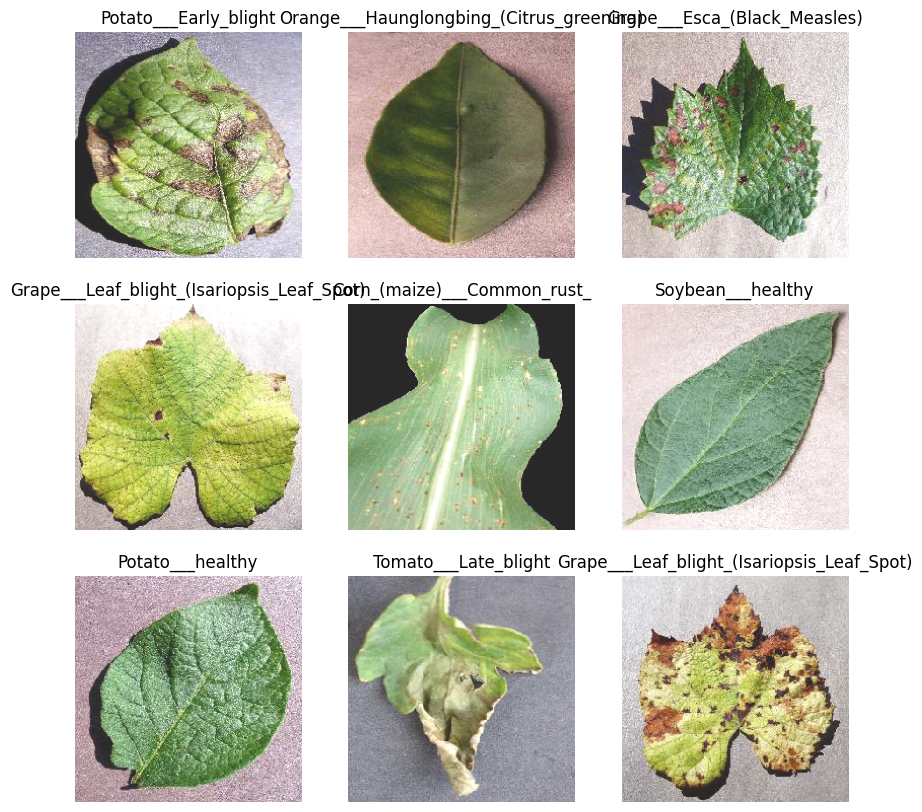

In [8]:
# @title 2. Data Loading and Preparation (Modified for Smaller Subset)

# Define paths to your PlantVillage subset generated by mvp_data_prep.ipynb
data_base_dir = os.path.join(MODULE1_DRIVE_DATA_DIR, 'PlantVillage_Subset')

train_data_dir = os.path.join(data_base_dir, 'train')
val_data_dir = os.path.join(data_base_dir, 'val')
test_data_dir = os.path.join(data_base_dir, 'test')

if not os.path.exists(train_data_dir):
    print(f"Error: Training data directory not found at {train_data_dir}")
    print("Please ensure 'mvp_data_prep.ipynb' has been run successfully and data exists in Google Drive.")
else:
    print(f"Loading data from: {data_base_dir}")

BATCH_SIZE = 32 # Keep consistent
IMG_HEIGHT, IMG_WIDTH = IMG_SIZE, IMG_SIZE # From models.py

# --- NEW: Limit dataset size for faster MVP runtime ---
# For a super quick run, limit to just a few batches or a very small percentage.
# We'll use the .take() method after shuffling.
SMALL_DATASET_TAKE_COUNT_TRAIN = 100 # Take only 100 batches for training (approx 3200 images)
SMALL_DATASET_TAKE_COUNT_VAL = 20    # Take only 20 batches for validation (approx 640 images)
SMALL_DATASET_TAKE_COUNT_TEST = 20   # Take only 20 batches for testing (approx 640 images)

print(f"WARNING: Limiting datasets to {SMALL_DATASET_TAKE_COUNT_TRAIN} training, {SMALL_DATASET_TAKE_COUNT_VAL} validation, and {SMALL_DATASET_TAKE_COUNT_TEST} test batches for faster MVP.")

# Create datasets (raw)
train_ds_raw = create_tf_dataset(train_data_dir, (IMG_HEIGHT, IMG_WIDTH), BATCH_SIZE, shuffle=True)
val_ds_raw = create_tf_dataset(val_data_dir, (IMG_HEIGHT, IMG_WIDTH), BATCH_SIZE, shuffle=False)
test_ds_raw = create_tf_dataset(test_data_dir, (IMG_HEIGHT, IMG_WIDTH), BATCH_SIZE, shuffle=False)

# Get class names
class_names = get_class_names(train_data_dir)
num_classes = len(class_names)
print(f"Found {num_classes} classes: {class_names}")

# Apply preprocessing and augmentation, THEN take a subset
train_ds = prepare_dataset(train_ds_raw, IMG_HEIGHT, IMG_WIDTH, augment=True).take(SMALL_DATASET_TAKE_COUNT_TRAIN)
val_ds = prepare_dataset(val_ds_raw, IMG_HEIGHT, IMG_WIDTH, augment=False).take(SMALL_DATASET_TAKE_COUNT_VAL)
test_ds = prepare_dataset(test_ds_raw, IMG_HEIGHT, IMG_WIDTH, augment=False).take(SMALL_DATASET_TAKE_COUNT_TEST)

print("Datasets created and prepared (subsetted for MVP).")

# Optional: Visualize a batch (will show images from the subset)
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(min(9, images.shape[0])): # Ensure we don't try to plot more than available images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [9]:
# @title 3. Model Definition and Compilation

model = build_fp32_efficientnet_model(num_classes)
model.summary()

# Define alpha weights for Weighted Focal Loss (MVP: just a placeholder example)
# For actual weighted focal loss, you'd calculate these based on your actual class frequencies.
dummy_alpha = np.ones(num_classes) * 0.5 # Example: all classes get 0.5 weight initially

# Compile the model with a potentially slightly higher learning rate for faster initial progress
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), # Slightly higher LR
    loss=WeightedFocalLoss(gamma=2.0, alpha=dummy_alpha),
    metrics=['accuracy']
)

print("Model defined and compiled.")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 35)             │         4,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,087,795 (23.22 MB)

 Trainable params: 168,483 (658.14 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

Model defined and compiled.


No existing checkpoint found. Starting training from scratch.
Starting training for 5 epochs, resuming from epoch 0...
Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4213 - loss: 1.0145
Epoch 1: saving model to /content/drive/MyDrive/AgroAI_Project_Data/module1_edge_ai/trained_models/fp32_mvp_baseline_checkpoints/model-epoch_0001_val_acc_0.6203.weights.h5

Epoch 1: val_accuracy improved from -inf to 0.62031, saving model to /content/drive/MyDrive/AgroAI_Project_Data/module1_edge_ai/trained_models/fp32_mvp_baseline_best_final.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 550s 6s/step - accuracy: 0.4222 - loss: 1.0125 - val_accuracy: 0.6203 - val_loss: 0.7819
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.7185 - loss: 0.4038
Epoch 2: saving model to /content/drive/MyDrive/AgroAI_Project_Data/module1_edge_ai/trained_models/fp32_mvp_baseline_checkpoints/model-epoch_0002_val_acc_0.7266.weights.h5

Epoch 2: val_accuracy improved from 0.62031 to 0.72656, saving model to /content/drive/MyDrive/AgroAI_Project_Data/module1_edge_ai/trained_models/fp32_mvp_baseline_best_final.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 56s 440ms/step - accuracy: 0.7187 - loss: 0.4034 - val_accuracy: 0.7266 - val_loss: 0.4233
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.8124 - loss: 0.2352
Epoch 3: saving model to /content/drive/MyDrive/AgroAI_Project_Data/module1_edge_ai/trained_models/fp32_mvp_baseline_checkpoints/model-epoch_0003_val_acc_0.7984.weights.h5

Epoch 3: val_accuracy improved from 0.72656 to 0.79844, saving model to /content/drive/MyDrive/AgroAI_Project_Data/module1_edge_ai/trained_models/fp32_mvp_baseline_best_final.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 304ms/step - accuracy: 0.8124 - loss: 0.2351 - val_accuracy: 0.7984 - val_loss: 0.2796
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.8549 - loss: 0.1610
Epoch 4: saving model to /content/drive/MyDrive/AgroAI_Project_Data/module1_edge_ai/trained_models/fp32_mvp_baseline_checkpoints/model-epoch_0004_val_acc_0.8438.weights.h5

Epoch 4: val_accuracy improved from 0.79844 to 0.84375, saving model to /content/drive/MyDrive/AgroAI_Project_Data/module1_edge_ai/trained_models/fp32_mvp_baseline_best_final.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 245ms/step - accuracy: 0.8549 - loss: 0.1611 - val_accuracy: 0.8438 - val_loss: 0.2136
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8616 - loss: 0.1324
Epoch 5: saving model to /content/drive/MyDrive/AgroAI_Project_Data/module1_edge_ai/trained_models/fp32_mvp_baseline_checkpoints/model-epoch_0005_val_acc_0.8953.weights.h5

Epoch 5: val_accuracy improved from 0.84375 to 0.89531, saving model to /content/drive/MyDrive/AgroAI_Project_Data/module1_edge_ai/trained_models/fp32_mvp_baseline_best_final.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 229ms/step - accuracy: 0.8617 - loss: 0.1324 - val_accuracy: 0.8953 - val_loss: 0.1549
Restoring model weights from the end of the best epoch: 5.
Training complete. Best model (overall) saved to: /content/drive/MyDrive/AgroAI_Project_Data/module1_edge_ai/trained_models/fp32_mvp_baseline_best_final.h5
Checkpoints saved to: /content/drive/MyDrive/AgroAI_Project_Data/module1_edge_ai/trained_models/fp32_mvp_baseline_checkpoints


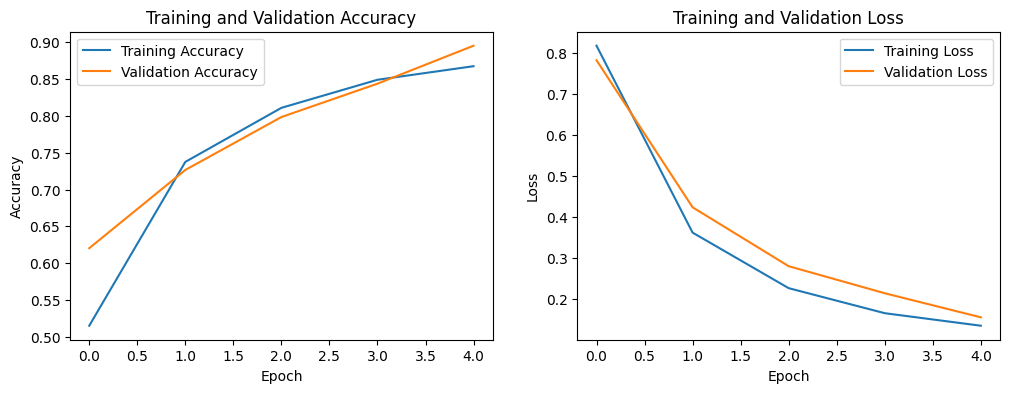

In [12]:
# @title 4. Model Training (Modified for Checkpointing and Resuming)

EPOCHS = 5 # Reduced number of epochs for MVP - further speed-up
MODEL_NAME = 'fp32_mvp_baseline'
CHECKPOINT_DIR = os.path.join(MODULE1_DRIVE_MODELS_DIR, f'{MODEL_NAME}_checkpoints')
# Ensure the checkpoint directory exists
os.makedirs(CHECKPOINT_DIR, exist_ok=True) # Make sure this directory is created

latest_checkpoint_path = tf.train.latest_checkpoint(CHECKPOINT_DIR)

# --- Resume from Checkpoint if available ---
initial_epoch = 0
if latest_checkpoint_path:
    print(f"Found existing checkpoint: {latest_checkpoint_path}. Attempting to resume training.")
    try:
        # For save_weights_only=True, we load weights onto the already defined model instance
        model.load_weights(latest_checkpoint_path)
        print("Model weights loaded successfully from checkpoint.")

        # Extract the epoch number from the checkpoint path
        # Example: 'model.weights.h5-epoch_0002_val_acc_0.8500'
        # Split by '_epoch_' and then get the first part and convert to int
        parts = os.path.basename(latest_checkpoint_path).split('_epoch_')
        if len(parts) > 1:
            initial_epoch = int(parts[1][:4]) # Take the first 4 chars (e.g., '0002')
            print(f"Resuming training from epoch: {initial_epoch + 1}") # Next epoch to train
        else:
            print("Could not parse epoch from checkpoint name. Resuming from epoch 0.")
            initial_epoch = 0

    except Exception as e:
        print(f"Error loading checkpoint weights: {e}. Starting training from scratch.")
        # Optionally, remove corrupted checkpoints or directory if load fails
        # shutil.rmtree(CHECKPOINT_DIR, ignore_errors=True) # Use with caution!
        initial_epoch = 0
else:
    print("No existing checkpoint found. Starting training from scratch.")

# Define callbacks
# ModelCheckpoint to save weights during training for resume
# Use a format that includes epoch number and validation accuracy
# CORRECTED LINE: The .weights.h5 must be at the very end
checkpoint_filepath_pattern = os.path.join(CHECKPOINT_DIR, 'model-epoch_{epoch:04d}_val_acc_{val_accuracy:.4f}.weights.h5')
#                                                                           ^ Correct position of .weights.h5

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_pattern,
    save_weights_only=True, # Save only weights, good for resuming
    monitor='val_accuracy',
    mode='max',
    save_best_only=False, # Save at each epoch for resume, not just best
    save_freq='epoch', # Save after each epoch
    verbose=1 # Changed to 1 for visible feedback on saving
)

# Callback to save the BEST overall model for final use (saves full model .h5)
# This callback saves the full model, so .h5 is the correct extension.
best_model_filepath = os.path.join(MODULE1_DRIVE_MODELS_DIR, f'{MODEL_NAME}_best_final.h5')
best_model_save_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=best_model_filepath,
    save_weights_only=False, # Save the entire model for easy loading
    monitor='val_accuracy',
    mode='max',
    save_best_only=True, # Only save the model if it's the best so far
    verbose=1
)

# EarlyStopping to prevent overfitting
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2, # Reduced patience for faster stopping
    restore_best_weights=True,
    verbose=1
)

print(f"Starting training for {EPOCHS} epochs, resuming from epoch {initial_epoch}...")
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[
        model_checkpoint_callback,
        best_model_save_callback,
        early_stopping_callback
    ],
    initial_epoch=initial_epoch # Start from this epoch
)

print(f"Training complete. Best model (overall) saved to: {best_model_filepath}")
print(f"Checkpoints saved to: {CHECKPOINT_DIR}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
# MODEL_NAME = 'fp32_mvp_baseline'
# best_model_filepath = os.path.join(MODULE1_DRIVE_MODELS_DIR, f'{MODEL_NAME}_best_final.h5')
# best_model_save_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=best_model_filepath,
#     save_weights_only=False, # Save the entire model for easy loading
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True, # Only save the model if it's the best so far
#     verbose=1
# )

# @title 5. Basic Model Evaluation on Test Set

print("\n--- Evaluating MVP Model on Test Set ---")

# First, try to load the full best model saved by `best_model_save_callback`
final_model_to_load = best_model_filepath
load_weights_only = False

if not os.path.exists(final_model_to_load):
    print(f"Warning: Best final model not found at {final_model_to_load}.")
    if latest_checkpoint_path:
        print(f"Attempting to load latest checkpoint instead: {latest_checkpoint_path}")
        final_model_to_load = latest_checkpoint_path
        load_weights_only = True
    else:
        raise FileNotFoundError("No model or checkpoint found to evaluate. Please ensure training completed successfully.")

try:
    if load_weights_only:
        # If loading weights only, we need to rebuild the model first
        best_model_for_eval = build_fp32_efficientnet_model(num_classes)
        best_model_for_eval.load_weights(final_model_to_load)
        # Recompile the model after loading weights (essential for evaluation)
        best_model_for_eval.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), # Use same LR as training
            loss=WeightedFocalLoss(gamma=2.0, alpha=dummy_alpha),
            metrics=['accuracy']
        )
        print("Model rebuilt and weights loaded for evaluation.")
    else:
        # If loading full model (.h5)
        best_model_for_eval = tf.keras.models.load_model(
            final_model_to_load,
            custom_objects={'WeightedFocalLoss': WeightedFocalLoss}
        )
        print("Best model (full .h5) loaded for evaluation.")

except Exception as e:
    print(f"FATAL ERROR: Could not load any model for evaluation: {e}")
    # Re-raise the error or handle gracefully based on desired behavior
    raise

loss, accuracy = best_model_for_eval.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Save class names to the module's data folder in Google Drive (if not already saved)
class_names_path = os.path.join(MODULE1_DRIVE_DATA_DIR, 'class_names.txt')
if not os.path.exists(class_names_path):
    with open(class_names_path, 'w') as f:
        for name in class_names:
            f.write(f"{name}\n")
    print(f"Class names saved to: {class_names_path}")
else:
    print(f"Class names already exist at: {class_names_path}")


--- Evaluating MVP Model on Test Set ---


Best model (full .h5) loaded for evaluation.
20/20 ━━━━━━━━━━━━━━━━━━━━ 102s 5s/step - accuracy: 0.8055 - loss: 0.5506
Test Loss: 0.3159
Test Accuracy: 0.8922
Class names saved to: /content/drive/MyDrive/AgroAI_Project_Data/module1_edge_ai/data/class_names.txt


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step

--- Mock Inference ---
True Class: Apple___Apple_scab
Predicted Class: Apple___Apple_scab
Predicted Confidence: 0.2885


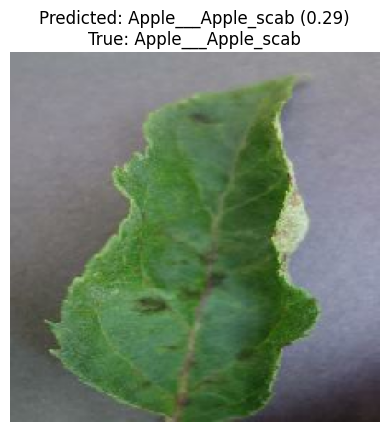


Module 1 FP32 MVP training and basic evaluation complete (fast version)!


In [10]:
# @title 6. Mock Inference Example with Saved Model (Using best model)

# Get one image from the test set for demonstration
for images, labels in test_ds.take(1):
    sample_image = images[0]
    sample_label = labels[0]
    break

# Add a batch dimension to the single image
sample_image_batch = tf.expand_dims(sample_image, axis=0)

# Make prediction
predictions = best_model_for_eval.predict(sample_image_batch)
predicted_class_idx = np.argmax(predictions[0])
predicted_confidence = np.max(predictions[0])

print(f"\n--- Mock Inference ---")
print(f"True Class: {class_names[sample_label.numpy()]}")
print(f"Predicted Class: {class_names[predicted_class_idx]}")
print(f"Predicted Confidence: {predicted_confidence:.4f}")

plt.imshow(sample_image.numpy().astype("uint8"))
plt.title(f"Predicted: {class_names[predicted_class_idx]} ({predicted_confidence:.2f})\nTrue: {class_names[sample_label.numpy()]}")
plt.axis("off")
plt.show()

print("\nModule 1 FP32 MVP training and basic evaluation complete (fast version)!")